# Stanford CME 241 (Winter 2024) - Assignment 6

**Due: Feb 19 @ 11:59pm Pacific Time on Gradescope.**

Assignment instructions:
- **Solve all 3 questions.**
- Empty code blocks are for your use. Feel free to create more under each section as needed.

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL and group members below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):*

https://github.com/HenriqueMonteiro35/RL-book/blob/master/assignment6.ipynb

*Group members (replace below names with people in your group):*
- Arantxa Ramos del Valle - aramosv
- Henrique Bittencourt Netto Monteiro - hbnm

## Imports

In [1]:
from rl.chapter2.simple_inventory_mrp import InventoryState, SimpleInventoryMRPFinite
from rl.function_approx import learning_rate_schedule, Tabular
from rl.approximate_dynamic_programming import ValueFunctionApprox
from rl.distribution import Choose
from rl.iterate import last
from rl.chapter10.prediction_utils import fmrp_episodes_stream
from rl.chapter10.prediction_utils import unit_experiences_from_episodes
from rl.monte_carlo import mc_prediction
import rl.td as td

from pprint import pprint
import itertools
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 12

## Question 1
We consider a special case of the Optimal Market-Making problem we
covered in class (Avellandea-Stoikov formulation) where the market-maker
has a cash amount of $W \in \mathbb{R}$ at time 0 and an inventory of
shares equal to $I \in \mathbb{Z}$ (note: this could be positive or
negative), but is not going to be market-making until time $T$. The
market maker's *Value Function* at time $t$ (with $0 \leq t \leq T$) is
given by the Expected Utility at time $T$ (conditional on the time $t$
and the OB Mid Price $S_t$ at time $t$):

$$V(t, S_t, W, I) = \mathbb{E}[-e^{-\gamma \cdot (W + I \cdot S_T)} | (t, S_t)]$$

Assume the same process for the OB Mid Price as we had covered in class:

$$dS_t = \sigma \cdot dz_t$$

for some fixed $\sigma \in \mathbb{R}^+$. This means:

$$S_{t_2} \sim \mathcal{N}(S_{t_1}, \sigma^2 \cdot (t_2 - t_1))$$

for all $0 \leq t_1 \leq t_2$.

-   Under this process for $S_t$, evaluate the conditional expectation
    $\mathbb{E}[-e^{-\gamma \cdot (W + I \cdot S_T)} | (t, S_t)]$ so you
    have a simple expression for $V(t, S_t, W, I)$.

-   Using the above expression for $V(t, S_t, W, I)$, calculate the
    Indifference Bid Price $Q^{(b)}(t, S_t, I)$ and the Indifference Ask
    Price $Q^{(a)}(t,S_t,I)$, which have the same definitions as we had
    covered in class, as follows:

    $$V(t,S_t,W - Q^{(b)}(t, S_t, I), I + 1) = V(t,S_t,W, I)$$
    $$V(t,S_t,W + Q^{(a)}(t, S_t, I), I - 1) = V(t,S_t,W, I)$$

**Answer:**
- Evaluate the conditional expectation:
  
$$V(t, S_t, W, I) = \mathbb{E}[-e^{-\gamma \cdot (W + I \cdot S_T)} | (t, S_t)] = -e^{-\gamma W}\cdot\mathbb{E}[e^{-\gamma I\cdot S_T}]$$


Knowing that $S_{t_2} \sim \mathcal{N}(S_{t_1}, \sigma^2 \cdot (t_2 - t_1))$, it means that when setting $t_2=T$:

$$S_{T} \sim \mathcal{N}(S_{t}, \sigma^2 \cdot (T - t))$$

Which is equivalent to:

$$S_{T} = S_{t} + \sigma \cdot \sqrt{T - t}\cdot Z$$
with $Z$ being the normal distribution. Now we incorporate this to the expression for the expectation:

$$V(t, S_t, W, I) = -e^{-\gamma W}e^{-\gamma I\cdot S_t}\cdot\mathbb{E}[e^{-\gamma I\cdot \sigma \cdot \sqrt{T - t}\cdot Z}]= -e^{-\gamma W-\gamma I\cdot S_t}\cdot e^{\frac{\gamma^2 I^2\cdot \sigma^2 \cdot (T - t)}2}$$

$$V(t, S_t, W, I) = -e^{-\gamma W-\gamma I\cdot S_t+\frac{\gamma^2 I^2\cdot \sigma^2 \cdot (T - t)}2}$$


- Calculate the Indifference Bid Price

$$V(t,S_t,W - Q^{(b)}(t, S_t, I), I + 1) = V(t,S_t,W, I)$$
$$-e^{-\gamma (W- Q^{(b)})-\gamma (I+1)\cdot S_t+\frac{\gamma^2 (I+1)^2\cdot \sigma^2 \cdot (T - t)}2} = -e^{-\gamma W-\gamma I\cdot S_t+\frac{\gamma^2 I^2\cdot \sigma^2 \cdot (T - t)}2}$$
$${-\gamma (W- Q^{(b)})-\gamma (I+1)\cdot S_t+\frac{\gamma^2 (I+1)^2\cdot \sigma^2 \cdot (T - t)}2} = {-\gamma W-\gamma I\cdot S_t+\frac{\gamma^2 I^2\cdot \sigma^2 \cdot (T - t)}2}$$
$${\gamma (Q^{(b)}+ S_t)+\frac{\gamma^2 (I^2+2I+1)\cdot \sigma^2 \cdot (T - t)}2} = \frac{\gamma^2 I^2\cdot \sigma^2 \cdot (T - t)}2$$
$${\gamma (Q^{(b)}+ S_t)+\frac{\gamma^2 (2I+1)\cdot \sigma^2 \cdot (T - t)}2} = 0$$
$$Q^{(b)} = S_t-\frac{\gamma (2I+1)\cdot \sigma^2 \cdot (T - t)}2 $$


- Calculate the Indifference Ask Price

Following the same process as before:

$$V(t,S_t,W + Q^{(a)}(t, S_t, I), I - 1) = V(t,S_t,W, I)$$
$$-e^{-\gamma (W+ Q^{(a)})-\gamma (I-1)\cdot S_t+\frac{\gamma^2 (I-1)^2\cdot \sigma^2 \cdot (T - t)}2} = -e^{-\gamma W-\gamma I\cdot S_t+\frac{\gamma^2 I^2\cdot \sigma^2 \cdot (T - t)}2}$$
$${-\gamma (W+ Q^{(a)})-\gamma (I-1)\cdot S_t+\frac{\gamma^2 (I-1)^2\cdot \sigma^2 \cdot (T - t)}2} = {-\gamma W-\gamma I\cdot S_t+\frac{\gamma^2 I^2\cdot \sigma^2 \cdot (T - t)}2}$$
$${-\gamma (Q^{(a)}+ S_t)+\frac{\gamma^2 (I^2-2I+1)\cdot \sigma^2 \cdot (T - t)}2} = \frac{\gamma^2 I^2\cdot \sigma^2 \cdot (T - t)}2$$
$${-\gamma (Q^{(a)}- S_t)-\frac{\gamma^2 (2I-1)\cdot \sigma^2 \cdot (T - t)}2} = 0$$
$$Q^{(a)} = S_t-\frac{\gamma (2I-1)\cdot \sigma^2 \cdot (T - t)}2 $$

## Question 2
We'd like to test the performance of the Optimal Policy we derived in
class for the Optimal Market-Making problem. In particular, we want to
compare this Optimal Policy against a policy (call it "Naive Policy")
that is always symmetric around the OB Mid Price (rather than around the
Indifference Price) with a constant Bid-Ask Spread equal to the average
Bid-Ask Spread of the Optimal Policy.

We will do the comparison by generating a large number of simulation
traces. Each simulation trace consists of $\frac T {\Delta t}$ time
steps. The time step $\Delta t$ needs to be small enough so that the
probability of multiple orders transacting with the market-maker is
small but needs to be large enough so that there are indeed orders that
transact with the market-maker. In their paper, Avallaneda-Stoikov point
out that $\Delta t = 0.005$ worked well in their simulation experiments.

Here are the details on how to perform a time step in each simulation
trace for the Optimal Policy:

-   At each time $t$, we observe the *State*, and calculate the Optimal
    Action $(P_t^{(b)^*}, P_t^{(a)^*})$.

-   With probability
    $c \cdot e^{-k \cdot \delta_t^{(a)^*}} \cdot \Delta t$, the
    inventory variable is decremented by 1 and the trading PnL is
    increased by $P_t^{(a)^*}$.

-   With probability
    $c \cdot e^{-k \cdot \delta_t^{(b)^*}} \cdot \Delta t$, the
    inventory variable is incremented by 1 and the trading PnL is
    decreased by $P_t^{(b)^*}$.

-   The OB Mid Price is incremented or decremented randomly (each with
    probability 0.5) by $\sigma \cdot \sqrt{\Delta t}$.

-   These updates to the inventory variable, to the trading PnL and to
    the OB Mid Price give us the *State* for the next time
    $t + \Delta t$.

We run a large number (say 10,000) such simulation traces. We calculate
the average Bid-Ask Spread across all time steps across all simulation
traces. Then we set the Bid-Ask Spread for the "naive policy" to be this
average Bid-Ask Spread (constant Bid-Ask Spread). Repeat the same large
number of simulations for the "naive policy".

Track the relevant metrics for each simulation trace on both the
policies - the trading PnL, the Inventory, the OB Mid Price, the Bid
Price, the Ask Price, the number of hits and lifts etc. Plot graphs for
these metrics. You can view the metrics on a single simulation trace or
you can view the average metrics at a fixed time (in particular for
terminal time $T$). Demonstrate empirically that the Optimal Policy does
indeed perform better than the "naive policy".

Avallaneda-Stoikov used the following parameters in their simulation:

$S_0 = 100, T = 1, \Delta t = 0.005, \gamma = 0.1, \sigma = 2, I_0 = 0, k = 1.5, c = 140$.

In [22]:
class MarketMaking:
    S_0: float = 100
    T: float = 1
    delta_t: float = 0.005
    gamma: float = 0.1
    sigma: float = 2
    W_0: float = 0
    I_0: int = 0
    k: float = 1.5
    c: float = 140

    def init(self):
        self.times = np.arange(0, self.T, self.delta_t)
        self.S_t = [self.S_0]
        for _ in self.times:
            if np.random.rand() < 0.5:
                self.S_t.append(self.S_t[-1] + self.sigma*np.sqrt(self.delta_t))
            else:
                self.S_t.append(self.S_t[-1] - self.sigma*np.sqrt(self.delta_t))

    def run(self, mode=None, constant_spread=None):
        W_t = self.W_0
        I_t = self.I_0

        PnL = []
        inventory = []
        mid_price = []
        bid_prices = []
        ask_prices = []

        list_hits = []
        list_lifts = []
        num_hits = 0
        num_lifts = 0
        for time, S_t in zip(self.times, self.S_t):

            if mode == "naive":
                delta_b = constant_spread / 2
                delta_a = constant_spread / 2
            elif mode == "optimal":
                delta_b = ((2*I_t + 1) * self.gamma * self.sigma**2 * (self.T - time))/2 + 1/self.gamma * np.log(1+self.gamma/self.k)
                delta_a = - ((2*I_t - 1) * self.gamma * self.sigma**2 * (self.T - time))/2 + 1/self.gamma * np.log(1+self.gamma/self.k)

            P_b = S_t - delta_b
            P_a = S_t + delta_a

            if np.random.rand() < self.c * np.exp(-self.k * delta_a) * self.delta_t:
                I_t -= 1
                W_t += P_a
                num_lifts += 1

            if np.random.rand() < self.c * np.exp(-self.k * delta_b) * self.delta_t:
                I_t += 1
                W_t -= P_b
                num_hits += 1

            list_hits.append(num_hits)
            list_lifts.append(num_lifts)
            PnL.append(W_t + I_t * S_t)
            inventory.append(I_t)
            mid_price.append(S_t)
            bid_prices.append(P_b)
            ask_prices.append(P_a)

        return PnL, inventory, mid_price, bid_prices, ask_prices, list_hits, list_lifts

In [43]:
num_simulations=1_000
market_maker = MarketMaking()
market_maker.init()

total_spread = 0
total_steps = 0
reward_opt = []

for _ in range(num_simulations):
    PnL_opt, inventory_opt, mid_price_opt, bid_prices_opt, ask_prices_opt, num_hits_opt, num_lifts_opt = market_maker.run(mode="optimal")
    total_spread += sum(ask - bid for ask, bid in zip(ask_prices_opt, bid_prices_opt))
    total_steps += len(bid_prices_opt)
    reward_opt.append(PnL_opt[-1])

average_spread = total_spread / total_steps

reward_n = []
total_num_hits_n = []
total_num_lifts_n = []

for _ in range(num_simulations):
    PnL_n, inventory_n, mid_price_n, bid_prices_n, ask_prices_n, num_hits_n, num_lifts_n = market_maker.run(mode="naive", constant_spread=average_spread)
    reward_n.append(PnL_n[-1])

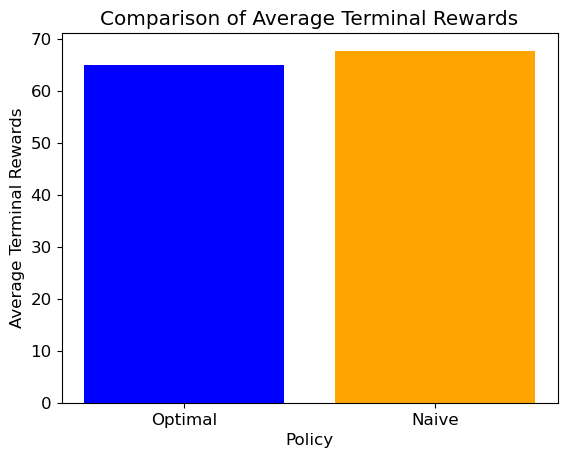

In [44]:
def plot_average_terminal_pnl(optimal_pnl, naive_pnl):
    policies = ['Optimal', 'Naive']
    pnl_values = [optimal_pnl, naive_pnl]

    plt.bar(policies, pnl_values, color=['blue', 'orange'])
    plt.xlabel('Policy')
    plt.ylabel('Average Terminal Rewards')
    plt.title('Comparison of Average Terminal Rewards')
    plt.show()

plot_average_terminal_pnl(np.mean(reward_opt), np.mean(reward_n))

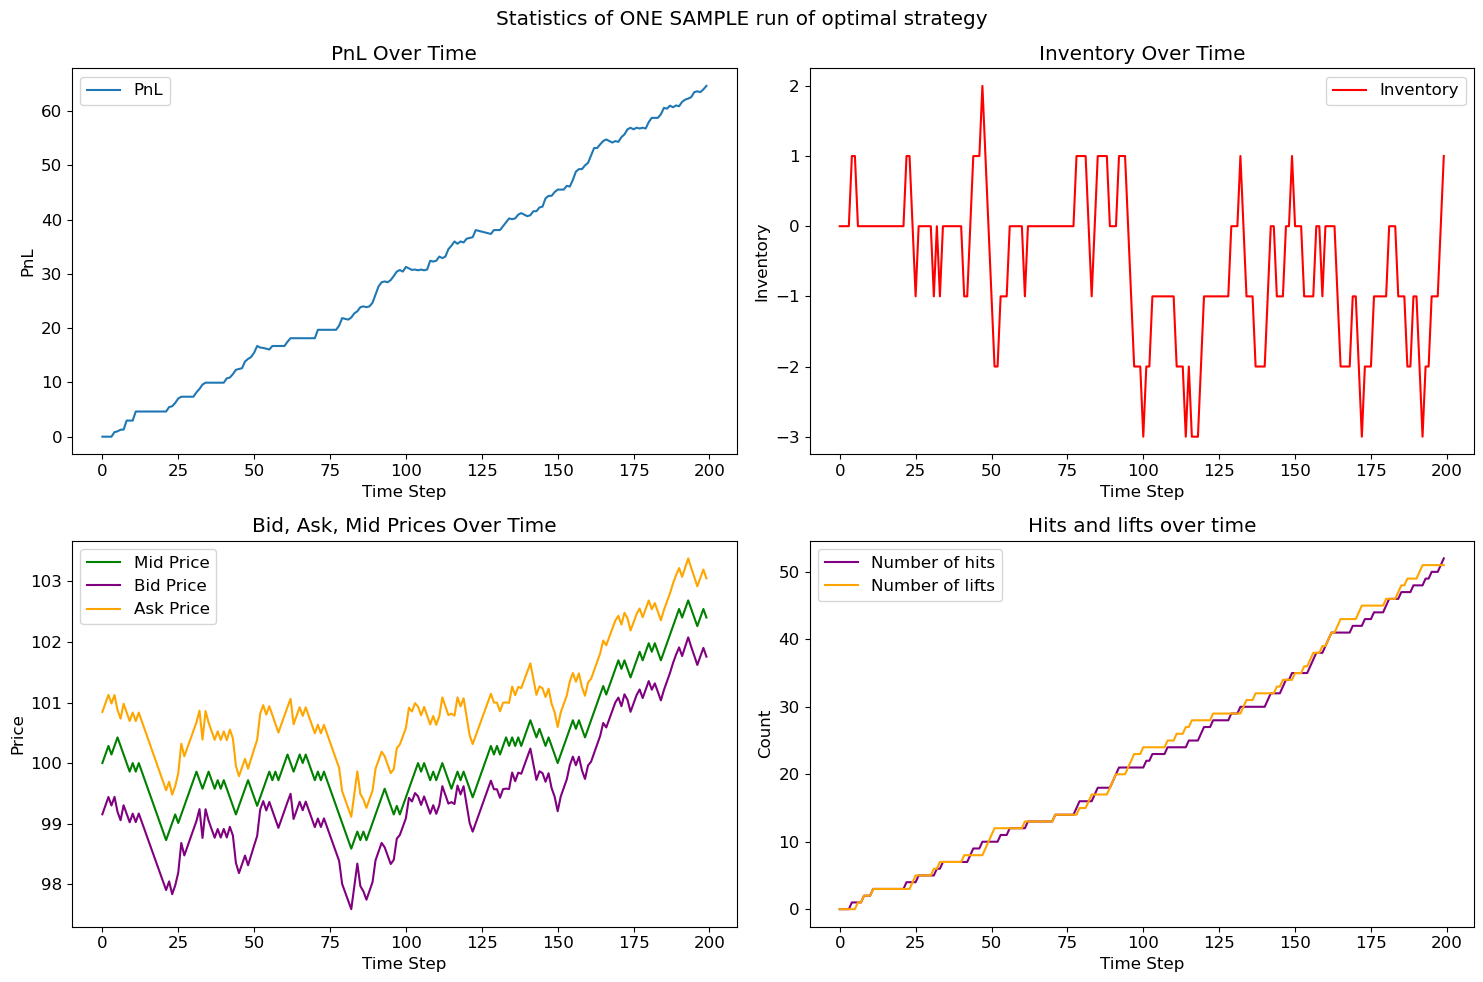

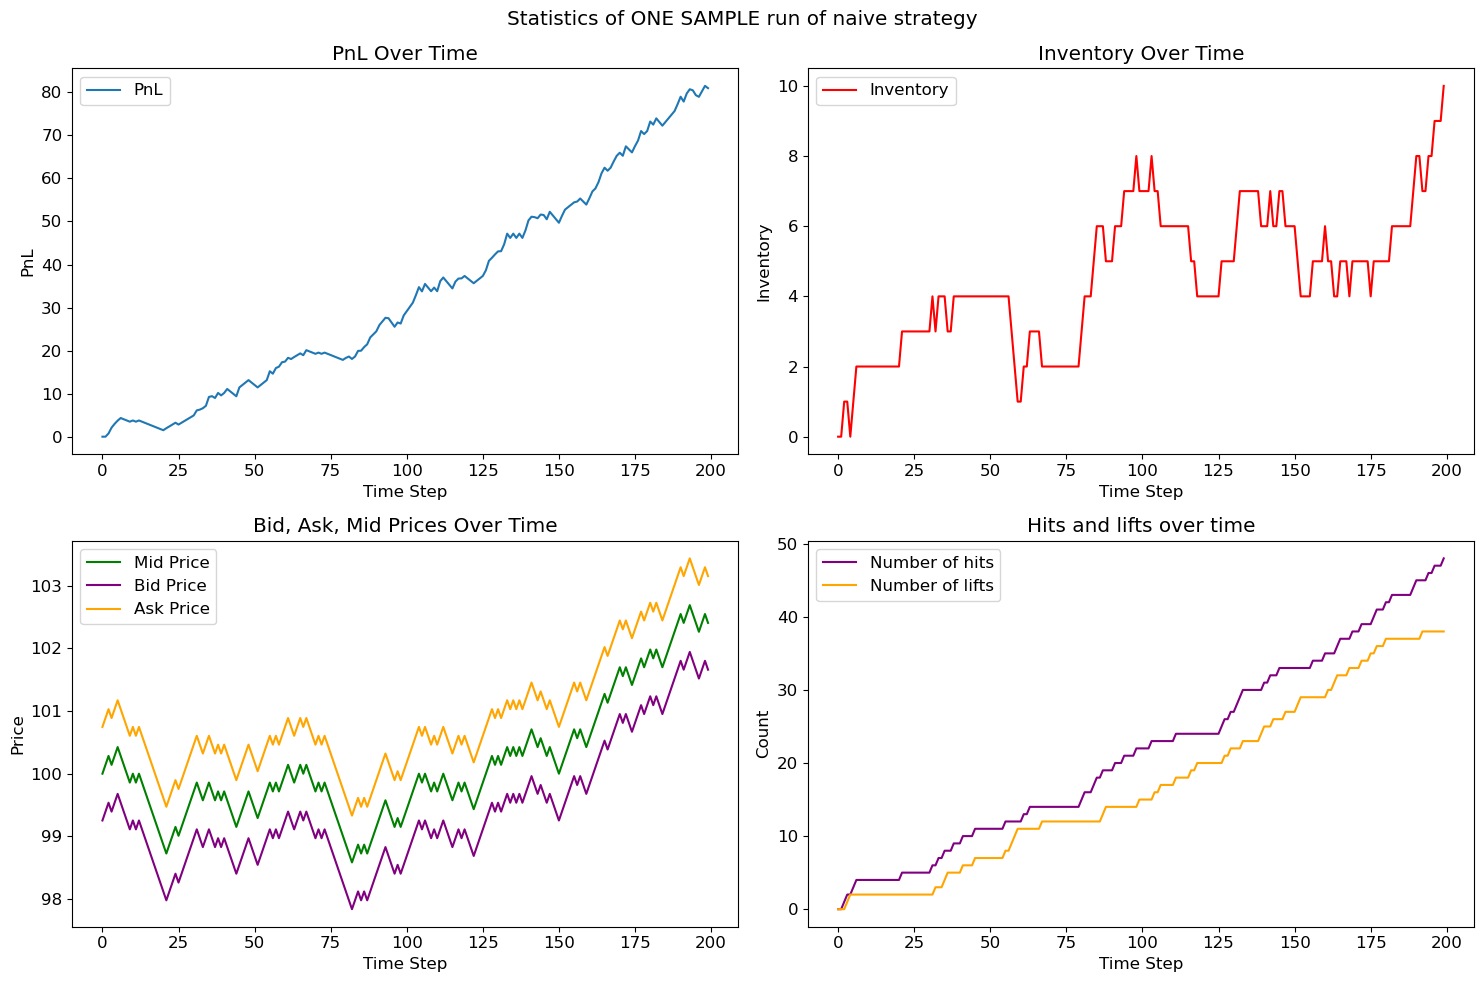

In [5]:
def plot_single_trace_metrics(pnl, inventory, mid_price, bid_price, ask_price, num_hits, num_lifts, mode=None):
    time_steps = list(range(len(pnl)))

    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Plot PnL
    axs[0, 0].plot(time_steps, pnl, label='PnL')
    axs[0, 0].set_title('PnL Over Time')
    axs[0, 0].set_xlabel('Time Step')
    axs[0, 0].set_ylabel('PnL')

    # Plot Inventory
    axs[0, 1].plot(time_steps, inventory, label='Inventory', color='red')
    axs[0, 1].set_title('Inventory Over Time')
    axs[0, 1].set_xlabel('Time Step')
    axs[0, 1].set_ylabel('Inventory')

    # Plot OB Mid, Bid, Ask Price
    axs[1, 0].plot(time_steps, mid_price, label='Mid Price', color='green')
    axs[1, 0].plot(time_steps, bid_price, label='Bid Price', color='purple')
    axs[1, 0].plot(time_steps, ask_price, label='Ask Price', color='orange')
    axs[1, 0].set_title('Bid, Ask, Mid Prices Over Time')
    axs[1, 0].set_xlabel('Time Step')
    axs[1, 0].set_ylabel('Price')

    # Plot Bid and Ask Prices
    axs[1, 1].plot(time_steps, num_hits, label='Number of hits', color='purple')
    axs[1, 1].plot(time_steps, num_lifts, label='Number of lifts', color='orange')
    axs[1, 1].set_title('Hits and lifts over time')
    axs[1, 1].set_xlabel('Time Step')
    axs[1, 1].set_ylabel('Count')

    for ax in axs.flat:
        ax.legend()

    fig.suptitle(f"Statistics of ONE SAMPLE run of {mode} strategy")
    plt.tight_layout()
    plt.show()

plot_single_trace_metrics(PnL_opt, inventory_opt, mid_price_opt, bid_prices_opt, ask_prices_opt, num_hits_opt, num_lifts_opt, mode="optimal")
plot_single_trace_metrics(PnL_n, inventory_n, mid_price_n, bid_prices_n, ask_prices_n, num_hits_n, num_lifts_n, mode="naive")

## Question 3
Although the provided code contains a number of utilties for Monte-Carlo
prediction, you may consider writing re-writing these functions to
improve your understanding.

1.  We have written the function `mc_prediction` in
    [rl/monte_carlo.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/monte_carlo.py)
    as an implementation of Monte-Carlo Prediction with function
    approximation. You have also learnt that since Tabular MC Prediction
    is a special case of MC Prediction with Function Approximation and
    so, writing a separate function for Tabular MC Prediction is not
    necessary. But for a learning experience, it's a great idea to write
    a function for Tabular MC Prediction **from scratch**. Think about
    what the input and output types must be. Be sure to reduce the
    learning rate appropriately as a function of number of updates (or
    as a function of number of episodes).

2.  We have written the function `td_prediction` in
    [rl/td.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/td.py)
    as an implementation of Temporal-Difference Prediction with function
    approximation. You have also learnt that since Tabular TD Prediction
    is a special case of TD Prediction with Function Approximation and
    so, writing a separate function for Tabular TD Prediction is not
    necessary. But for a learning experience, it's a great idea to write
    a function for Tabular TD Prediction **from scratch**. Think about
    what the input and output types must be. Be sure to reduce the
    learning rate appropriately as a function of number of updates.

3.  Test your above implementations of Tabular MC Prediction and Tabular
    TD Prediction on\
    `SimpleInventoryMRPFinite` (from
    [rl/chapter2/simple_inventory_mrp.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter2/simple_inventory_mrp.py))
    by ensuring that your Value Function output matches that produced by
    the function approximation versions of MC Prediction and TD
    Prediction.

### PROBLEM SPECS

In [6]:
# MRP SPECS
user_capacity = 2
user_poisson_lambda = 1.0
user_holding_cost = 1.0
user_stockout_cost = 10.0
gamma = 0.9

# MC SPECS
num_traces = 10_000
episode_length_tolerance = 1e-6

# TD SPECS
num_episodes = 10_000
episode_length = 100
initial_learning_rate = 0.03
half_life = 1000.0
exponent = 0.5

### MRP DEFINITION

In [7]:
si_mrp = SimpleInventoryMRPFinite(
    capacity=user_capacity,
    poisson_lambda=user_poisson_lambda,
    holding_cost=user_holding_cost,
    stockout_cost=user_stockout_cost
)

si_mrp.display_value_function(gamma=gamma)

{NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -39.329,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -37.971,
 NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -43.596,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -38.971,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -37.329,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -38.329}


### GET LISTS OF EPISODES

In [8]:
def get_list_episodes(num, episode_length=None):
    episodes = []
    for episode in fmrp_episodes_stream(si_mrp):
        transitions = []
        for j, transition in enumerate(episode):
            transitions.append(transition)
            # STOPPING CRITERIA FOR EACH EPISODE
            if episode_length is not None:
                if j == episode_length:
                    break
            elif gamma**j < episode_length_tolerance:
                break
        episodes.append(transitions)
        if len(episodes) == num:
            return episodes

### OUR TABULAR MC

In [9]:
def get_tabular_mc_vf(episodes_list):
    counter = {s: 0 for s in si_mrp.non_terminal_states}
    values = {s: 0 for s in si_mrp.non_terminal_states}
    for episode in episodes_list:
        state = episode[0].state
        Y_i = sum([transition.reward * gamma**i for i, transition in enumerate(episode)])
        values[state] = counter[state]/(counter[state]+1) * values[state] + 1/(counter[state]+1) * Y_i
        counter[state] += 1

    return {s: round(values[s], 3) for s in si_mrp.non_terminal_states}

### OUR TABULAR TD

In [10]:
def get_tabular_td_vf(episodes_list):
    counter = {s: 0 for s in si_mrp.non_terminal_states}
    values = {s: 0 for s in si_mrp.non_terminal_states}
    for episode in episodes_list:
        for transition in episode:
            state = transition.state
            td_error = (transition.reward + gamma * values[transition.next_state]) - values[state]
            alpha = initial_learning_rate / ((1 + counter[state]/half_life)**exponent)
            values[state] += alpha * td_error
            counter[state] += 1

    return {s: round(values[s], 3) for s in si_mrp.non_terminal_states}

### BOOK MC

In [11]:
def get_book_mc_vf():
    traces = si_mrp.reward_traces(Choose(si_mrp.non_terminal_states))
    it = mc_prediction(
        traces=traces,
        approx_0=Tabular(),
        γ=gamma,
        episode_length_tolerance=episode_length_tolerance,
    )

    last_func = last(itertools.islice(it, num_traces))
    return {s: round(last_func.evaluate([s])[0], 3) for s in si_mrp.non_terminal_states}

### BOOK TD

In [12]:
def get_book_td_vf():
    episodes = fmrp_episodes_stream(si_mrp)
    td_experiences = unit_experiences_from_episodes(episodes, episode_length)
    learning_rate_func = learning_rate_schedule(
        initial_learning_rate=initial_learning_rate,
        half_life=half_life,
        exponent=exponent
    )
    td_vfs = td.td_prediction(
        transitions=td_experiences,
        approx_0=Tabular(count_to_weight_func=learning_rate_func),
        γ=gamma
    )

    final_td_vf = last(itertools.islice(td_vfs, episode_length * num_episodes))
    return {s: round(final_td_vf(s), 3) for s in si_mrp.non_terminal_states}

### COMPARISON

In [13]:
episodes_mc = get_list_episodes(num=num_traces)
tabular_mc = get_tabular_mc_vf(episodes_mc)
episodes_td = get_list_episodes(num=num_episodes, episode_length=episode_length)
tabular_td = get_tabular_td_vf(episodes_td)

book_mc = get_book_mc_vf()
book_td = get_book_td_vf()

In [14]:
print("*** VALUE FUNCTION FROM BOOK MC ***")
pprint(book_mc)

print("\n*** VALUE FUNCTION FROM OUR TABULAR MC ***")
pprint(tabular_mc)

*** VALUE FUNCTION FROM BOOK MC ***
{NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -39.367,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -37.992,
 NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -43.612,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -38.968,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -37.346,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -38.337}

*** VALUE FUNCTION FROM OUR TABULAR MC ***
{NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -38.917,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -38.032,
 NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -43.534,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -39.22,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -37.186,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -38.071}


In [15]:
print("\n*** VALUE FUNCTION FROM BOOK TD ***")
pprint(book_td)

print("\n*** VALUE FUNCTION FROM OUR TABULAR TD ***")
pprint(tabular_td)


*** VALUE FUNCTION FROM BOOK TD ***
{NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -39.243,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -37.907,
 NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -43.585,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -39.083,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -37.394,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -38.276}

*** VALUE FUNCTION FROM OUR TABULAR TD ***
{NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -39.464,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -37.838,
 NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -43.596,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -39.041,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -37.27,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -38.408}


#### **NOTE:** the small differences observed are expected due to the stochastic nature of the generated traces/episodes.